In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from teren.dir_act_utils import *

SEED = 0
LAYER = 0
SEQ_LEN = 32
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")
# TODO
N_PROMPTS = INFERENCE_BATCH_SIZE * 5

INFERENCE_BATCH_SIZE=400


In [3]:
from teren import utils as teren_utils

device = teren_utils.get_device_str()
print(f"{device=}")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)
d_model = model.cfg.d_model
input_ids = get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]
resid_acts = get_clean_resid_acts(model, LAYER, input_ids, INFERENCE_BATCH_SIZE)

device='cuda'
Loaded pretrained model gpt2-small into HookedTransformer


  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
torch.manual_seed(SEED)
dir = torch.randn(d_model)
dir = dir / dir.norm()

In [5]:
import matplotlib.pyplot as plt


def plot_multi_dir_hist(
    model: HookedTransformer,
    layer: int,
    dirs: Float[torch.Tensor, "dir model"],
    resid_acts: Float[torch.Tensor, "prompt seq model"],
    batch_size: int,
    acts_q_range: tuple[float, float],
    bins: int,
):
    counts = torch.zeros(bins, dtype=torch.int)
    for dir in dirs:
        counts += dir_to_js_dist_hist(
            model, layer, dir, resid_acts, batch_size, acts_q_range, bins
        )
    plt.bar(torch.arange(bins), counts)

In [6]:
def get_random_dirs(d_model, n_dirs, seed):
    torch.manual_seed(seed)
    dir = torch.randn((n_dirs, d_model))
    return dir / dir.norm(dim=-1, keepdim=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

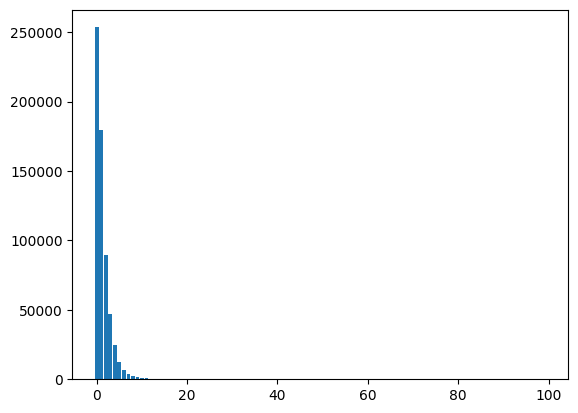

In [10]:
plot_multi_dir_hist(
    model,
    LAYER,
    get_random_dirs(d_model, 10, 0),
    resid_acts,
    INFERENCE_BATCH_SIZE,
    (0.01, 0.95),
    100,
)

In [11]:
from teren.saes import SAE_ID_BY_LAYER_BY_FAMILY
from sae_lens import SAE
import random

sae_family = "gpt2-small-res-jb"
sae_id = SAE_ID_BY_LAYER_BY_FAMILY[sae_family][LAYER]
sae = SAE.from_pretrained(release=sae_family, sae_id=sae_id, device=device)[0]


def get_random_sae_dirs(sae, n_dirs, seed):
    random.seed(seed)
    fids = random.sample(range(sae.cfg.d_sae), n_dirs)
    return sae.W_dec[fids].cpu()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

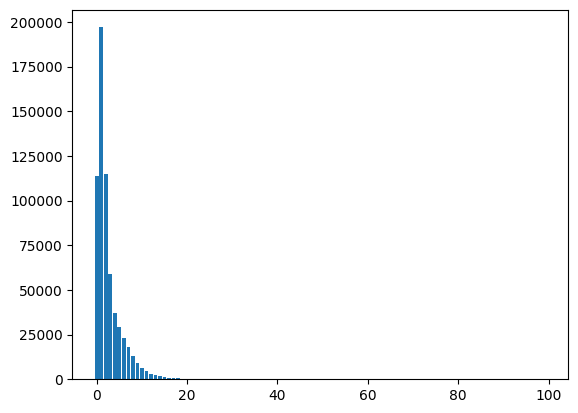

In [12]:
plot_multi_dir_hist(
    model,
    LAYER,
    get_random_sae_dirs(sae, 10, 0),
    resid_acts,
    INFERENCE_BATCH_SIZE,
    (0.01, 0.95),
    100,
)